## Import needed libraries

In [18]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.linear_model import (LinearRegression,
                                  Ridge, 
                                  Lasso, 
                                  ElasticNet)
from sklearn.metrics import (mean_squared_error,
                             r2_score, 
                             mean_squared_log_error,
                             mean_absolute_error)
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (OneHotEncoder,
                                   PolynomialFeatures, 
                                   KBinsDiscretizer, 
                                   MinMaxScaler)

## Load in data

In [19]:
df = pd.read_csv('./data/train.csv')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Split the data for training

In [20]:
X = df.drop('count', axis=1)
y = df['count']

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 10)

In [22]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((8708, 11), (8708,), (2178, 11), (2178,))

In [23]:
df_train = pd.concat([X_train, y_train], axis=1)
df_val = pd.concat([X_val, y_val], axis=1)

In [24]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
7038,2012-04-11 15:00:00,2,0,1,3,15.58,19.695,46,15.0013,50,152,202
4114,2011-10-03 11:00:00,4,0,1,2,16.40,20.455,71,15.0013,26,100,126
5720,2012-01-13 12:00:00,1,0,1,1,9.84,9.850,38,32.9975,14,140,154
3219,2011-08-04 01:00:00,3,0,1,2,27.06,29.545,94,6.0032,3,14,17
10711,2012-12-12 17:00:00,4,0,1,2,13.12,15.150,53,15.0013,21,540,561


In [25]:
df_train.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

### We need an actual datetime column!

* Let's add some other features that can help us find trends.

In [26]:
def create_datetime(df):
    
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['week'] = df['datetime'].dt.isocalendar().week
    df['day_of_week'] = df['datetime'].dt.weekday
    
    df.drop(['datetime'], axis=1, inplace=True)

In [27]:
create_datetime(df_train)
create_datetime(df_val)
df_train.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,week,day_of_week
7038,2,0,1,3,15.58,19.695,46,15.0013,50,152,202,2012,4,11,15,15,2
4114,4,0,1,2,16.40,20.455,71,15.0013,26,100,126,2011,10,3,11,40,0


In [28]:
df_train.isnull().sum() 

season         0
holiday        0
workingday     0
weather        0
temp           0
atemp          0
humidity       0
windspeed      0
casual         0
registered     0
count          0
year           0
month          0
day            0
hour           0
week           0
day_of_week    0
dtype: int64

### No Nan, but let's see if there are any fake out 0 values

In [29]:
df_train[df_train['temp']==0]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,week,day_of_week


* The humidity is only 0 for only one day in March...

* Is that a real 0 or not?

* I think it's real.

In [30]:
df_train[df_train['humidity']==0]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,week,day_of_week
1097,1,0,1,3,15.58,19.695,0,19.0012,1,43,44,2011,3,10,8,10,3
1105,1,0,1,3,17.22,21.210,0,16.9979,1,20,21,2011,3,10,16,10,3
1112,1,0,1,3,13.94,17.425,0,6.0032,1,26,27,2011,3,10,23,10,3
1110,1,0,1,3,14.76,17.425,0,15.0013,1,27,28,2011,3,10,21,10,3
1094,1,0,1,3,14.76,17.425,0,12.9980,1,2,3,2011,3,10,5,10,3
1092,1,0,1,3,13.94,15.910,0,16.9979,0,2,2,2011,3,10,1,10,3
1104,1,0,1,3,18.04,21.970,0,15.0013,3,11,14,2011,3,10,15,10,3
1102,1,0,1,3,17.22,21.210,0,15.0013,1,11,12,2011,3,10,13,10,3
1107,1,0,1,3,18.04,21.970,0,23.9994,2,80,82,2011,3,10,18,10,3
1099,1,0,1,3,16.40,20.455,0,11.0014,0,17,17,2011,3,10,10,10,3


* Are there any false 0s in the windspeed?

* ...Maybe? I think these 0s are also real.

In [31]:
df_train[df_train['windspeed']==0]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,week,day_of_week
8832,3,0,1,2,26.24,28.790,89,0.0,21,199,220,2012,8,10,9,32,4
4109,4,0,1,2,14.76,18.940,71,0.0,3,91,94,2011,10,3,6,40,0
4272,4,1,0,1,19.68,23.485,88,0.0,4,30,34,2011,10,10,1,41,0
442,1,0,1,2,8.20,12.880,86,0.0,2,53,55,2011,2,1,12,5,1
9098,3,0,0,2,30.34,34.850,70,0.0,226,263,489,2012,9,2,11,35,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7512,2,0,0,1,22.14,25.760,49,0.0,87,248,335,2012,5,12,9,19,5
2693,3,0,1,1,26.24,31.060,53,0.0,5,6,11,2011,7,1,3,26,4
8281,3,0,1,1,35.26,37.120,30,0.0,80,130,210,2012,7,6,10,27,4
574,1,0,1,1,8.20,12.880,80,0.0,0,3,3,2011,2,7,2,6,0


## Let's track how seasons affect bike rentals

* Looks like May-October is the busiest.

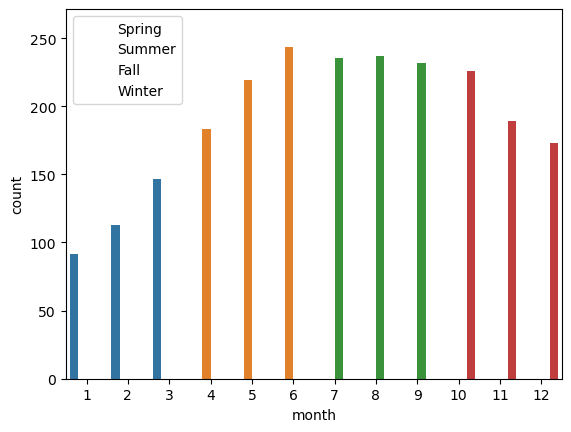

In [32]:
seasons = ['Spring', 'Summer', 'Fall', 'Winter']
fig, ax = plt.subplots()
sns.barplot(data=df_train, x="month", y="count", hue="season", errwidth=0)
plt.legend(seasons)

In [33]:
df_corr = df_train.drop(['casual', 'registered', 'atemp'], axis=1)
corr = df_corr.corr()
corr

,season,holiday,workingday,weather,temp,humidity,windspeed,count,year,month,day,hour,week,day_of_week
season,1.000000,0.030048,-0.009485,0.004764,0.248050,0.190976,-0.148302,0.156602,-0.009101,0.971535,-0.003869,-0.014409,0.937401,-0.010758
holiday,0.030048,1.000000,-0.249031,-0.003858,-0.009700,0.008911,0.012572,-0.009234,0.005213,0.003596,-0.010900,-0.003738,0.002856,-0.190877
workingday,-0.009485,-0.249031,1.000000,0.027982,0.029380,-0.020347,0.010025,0.014936,-0.004279,-0.005302,0.008222,0.015987,-0.026318,-0.705406
weather,0.004764,-0.003858,0.027982,1.000000,-0.061167,0.406284,0.005449,-0.133023,-0.015100,0.007351,-0.004456,-0.028945,0.016794,-0.047141
temp,0.248050,-0.009700,0.029380,-0.061167,1.000000,-0.067032,-0.012384,0.397468,0.055761,0.247442,0.010469,0.146930,0.229911,-0.034133
humidity,0.190976,0.008911,-0.020347,0.406284,-0.067032,1.000000,-0.317906,-0.321483,-0.083392,0.205570,-0.003268,-0.276177,0.218433,-0.024103
windspeed,-0.148302,0.012572,0.010025,0.005449,-0.012384,-0.317906,1.000000,0.104207,-0.012480,-0.150293,0.028080,0.146172,-0.145824,-0.017098
count,0.156602,-0.009234,0.014936,-0.133023,0.397468,-0.321483,0.104207,1.000000,0.251979,0.159958,0.016225,0.399332,0.144654,-0.002919
year,-0.009101,0.005213,-0.004279,-0.015100,0.055761,-0.083392,-0.012480,0.251979,1.000000,-0.009027,0.003349,-0.009458,-0.008209,-0.002612
month,0.971535,0.003596,-0.005302,0.007351,0.247442,0.205570,-0.150293,0.159958,-0.009027,1.000000,-0.001307,-0.014152,0.959693,-0.002756


* Count is very correlated to day, temp, and humidity.
* Atemp and temp are correlated to each other, so we only need one

<AxesSubplot:>

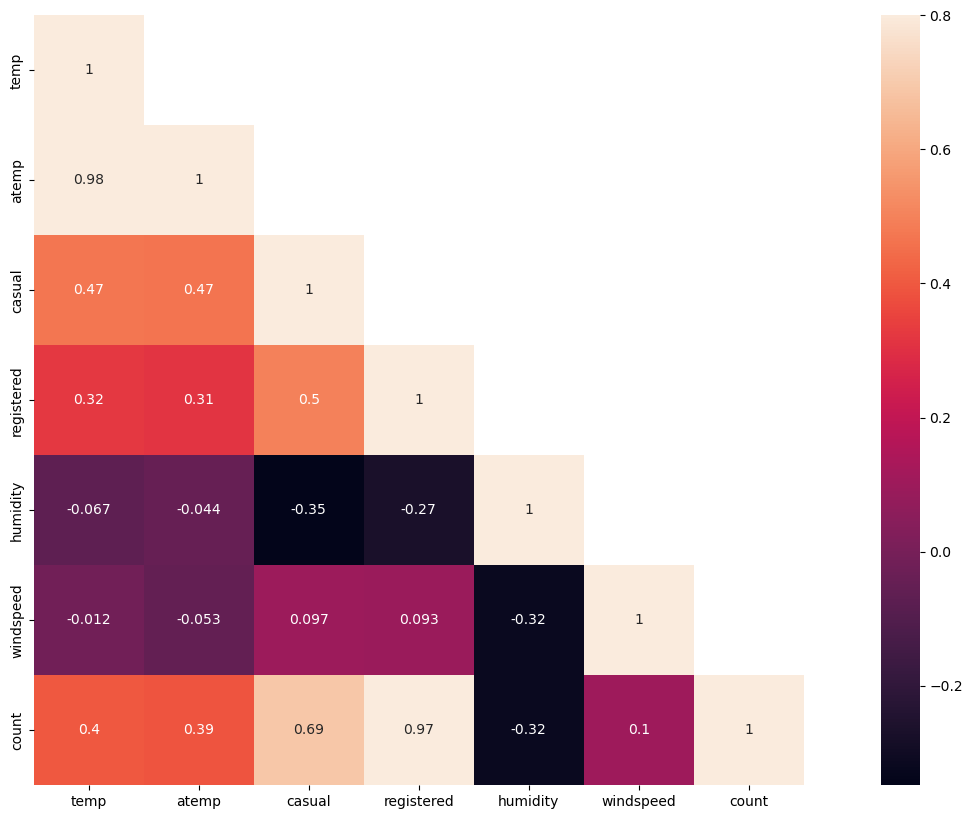

In [34]:
corrMatt = df_train[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

<AxesSubplot:xlabel='hour'>

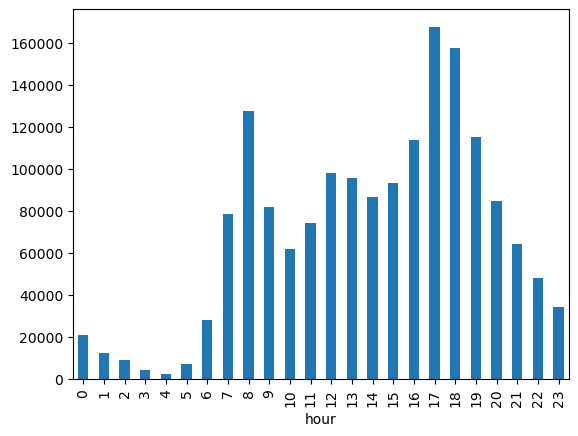

In [35]:
df_train.groupby(['hour'])['count'].sum().plot.bar()

In [36]:
df_weather1 = df_train.loc[df_train['weather']==1]
df_weather2 = df_train.loc[df_train['weather']==2]
df_weather3 = df_train.loc[df_train['weather']==3]
df_weather4 = df_train.loc[df_train['weather']==4]

* When the weather is really nice, registered riders ride home more often.
* If the weather is bad, it seems registered riders ride home at a different proportion.

* Casual riders seem to have very different habits. 
* We should train our model separately as well.

/var/folders/h1/vgc6dlns12lcdg0rg16y4stw0000gn/T/ipykernel_59655/2083065726.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_weather1.groupby(['hour'])['casual', 'registered'].sum().plot.bar()


<AxesSubplot:xlabel='hour'>

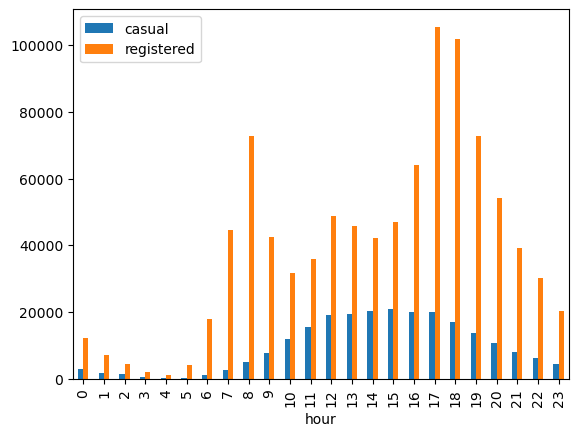

In [37]:
df_weather1.groupby(['hour'])['casual', 'registered'].sum().plot.bar()

/var/folders/h1/vgc6dlns12lcdg0rg16y4stw0000gn/T/ipykernel_59655/1475268749.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_weather2.groupby(['hour'])['casual', 'registered'].sum().plot.bar()


<AxesSubplot:xlabel='hour'>

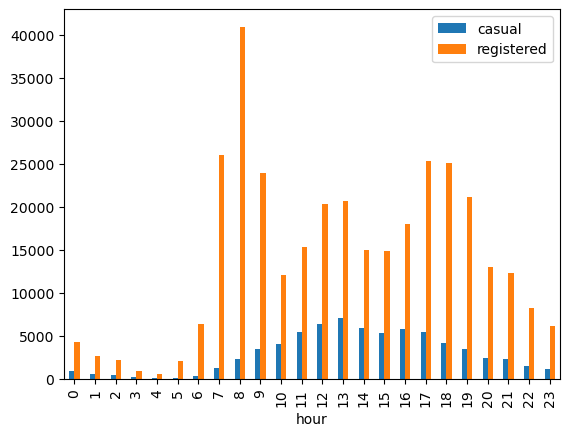

In [38]:
df_weather2.groupby(['hour'])['casual', 'registered'].sum().plot.bar()

/var/folders/h1/vgc6dlns12lcdg0rg16y4stw0000gn/T/ipykernel_59655/3685197904.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_weather3.groupby(['hour'])['casual', 'registered'].sum().plot.bar()


<AxesSubplot:xlabel='hour'>

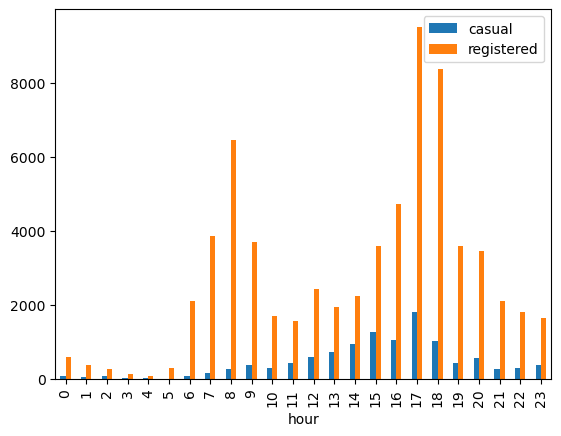

In [39]:
df_weather3.groupby(['hour'])['casual', 'registered'].sum().plot.bar()

### Only one day had a weather rating of 4. Therefore, we could drop this day.

In [40]:
df_weather4#.groupby(['hour'])['casual', 'registered'].sum().plot.bar()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,week,day_of_week
5631,1,0,1,4,8.2,11.365,86,6.0032,6,158,164,2012,1,9,18,2,0


In [41]:
groupby_hour_season = pd.DataFrame({'mean':df_train.groupby(['hour','season'], 
                                                           sort=True)['count'].mean()}).reset_index()
groupby_hour_weekday = pd.DataFrame({'mean':df_train.groupby(['hour','day_of_week'], 
                                                           sort=True)['count'].mean()}).reset_index()

* Weekends have very different behavior.
* We could add complexity and split our model further, but perhaps this is overkill?

<AxesSubplot:xlabel='hour', ylabel='mean'>

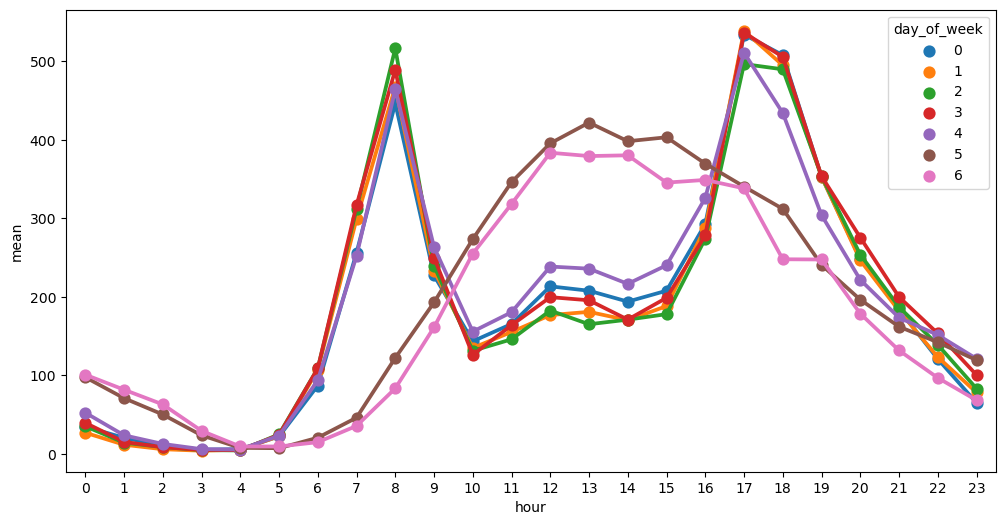

In [42]:
plt.figure(figsize=(12,6))
sns.pointplot(data=groupby_hour_weekday, x="hour", y="mean", hue='day_of_week')

<AxesSubplot:xlabel='hour', ylabel='mean'>

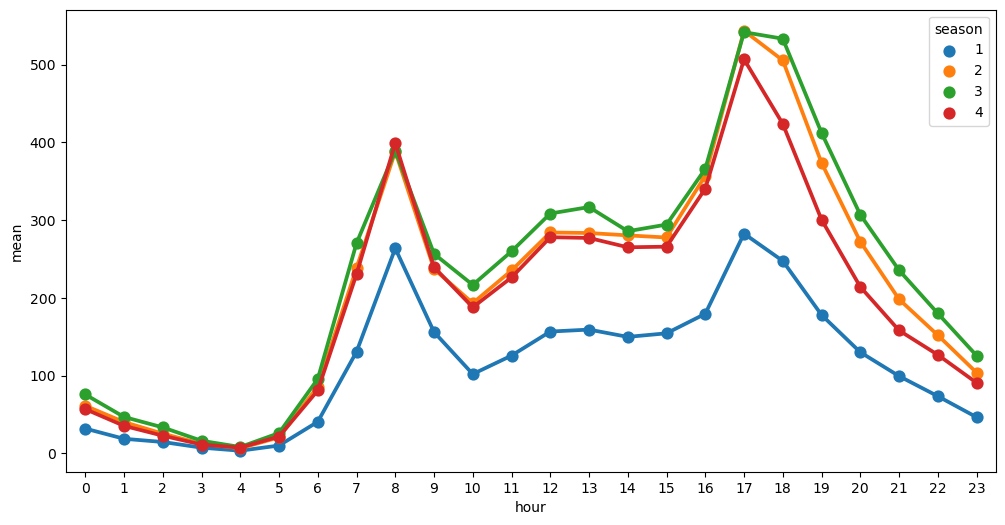

In [43]:
plt.figure(figsize=(12,6))
sns.pointplot(data=groupby_hour_season, x="hour", y="mean", hue='season')

#### We can see that we do not have a normal distribution, therefore we should use the log function on our data.

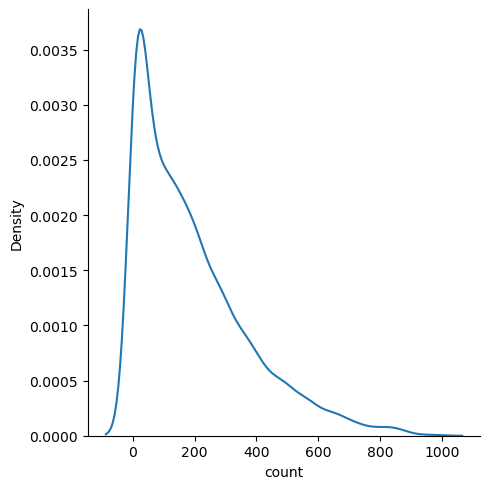

In [44]:
# We can see the need for using log
sns.displot(data=df_train, x="count", kind='kde')

<AxesSubplot:ylabel='Density'>

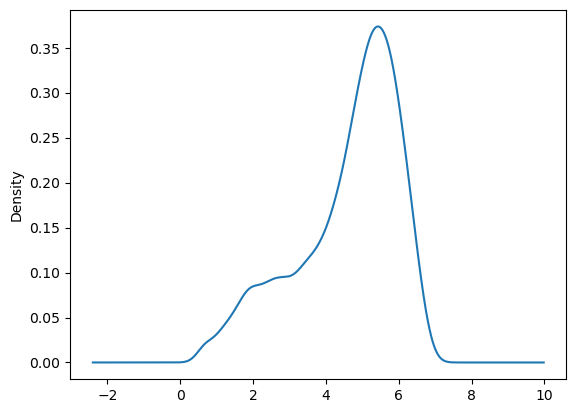

In [45]:
import math
df_train['count_log'] = np.log1p(df_train['count'])
df_train['count_log'].plot(kind='kde')

### Do we have some outlier days affecting our model. If so, let's get rid of those.

/Users/briana/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


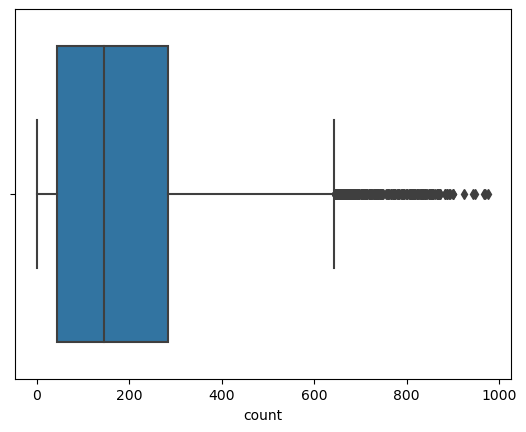

The lower/upper boundary is -348.96883606678176/731.9082021669196
There are 114 outliers based on 3-sigma rule


In [46]:
# calculate the mean and standard deviation of the data
mean = np.mean(df_train['count'])
std = np.std(df_train['count'])

# define the cutoff for what constitutes an outlier
cutoff = 3 * std

# boxplot
sns.boxplot(df_train['count'], orient="h")
plt.show()

# print lower, upper boundry
lower, upper = mean-3*std, mean+3*std
print(f"The lower/upper boundary is {lower}/{upper}")

# identify outliers
outliers = [x for x in df_train['count'] if np.abs(x - mean) > cutoff]
print(f"There are {len(outliers)} outliers based on 3-sigma rule")
#return outliers


# We can clearly see that there are several outliers, especially on the casual riders.

[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Casual Count'),
 Text(0.5, 1.0, 'Box Plot On Casual Count Across Hour Of The Day')]

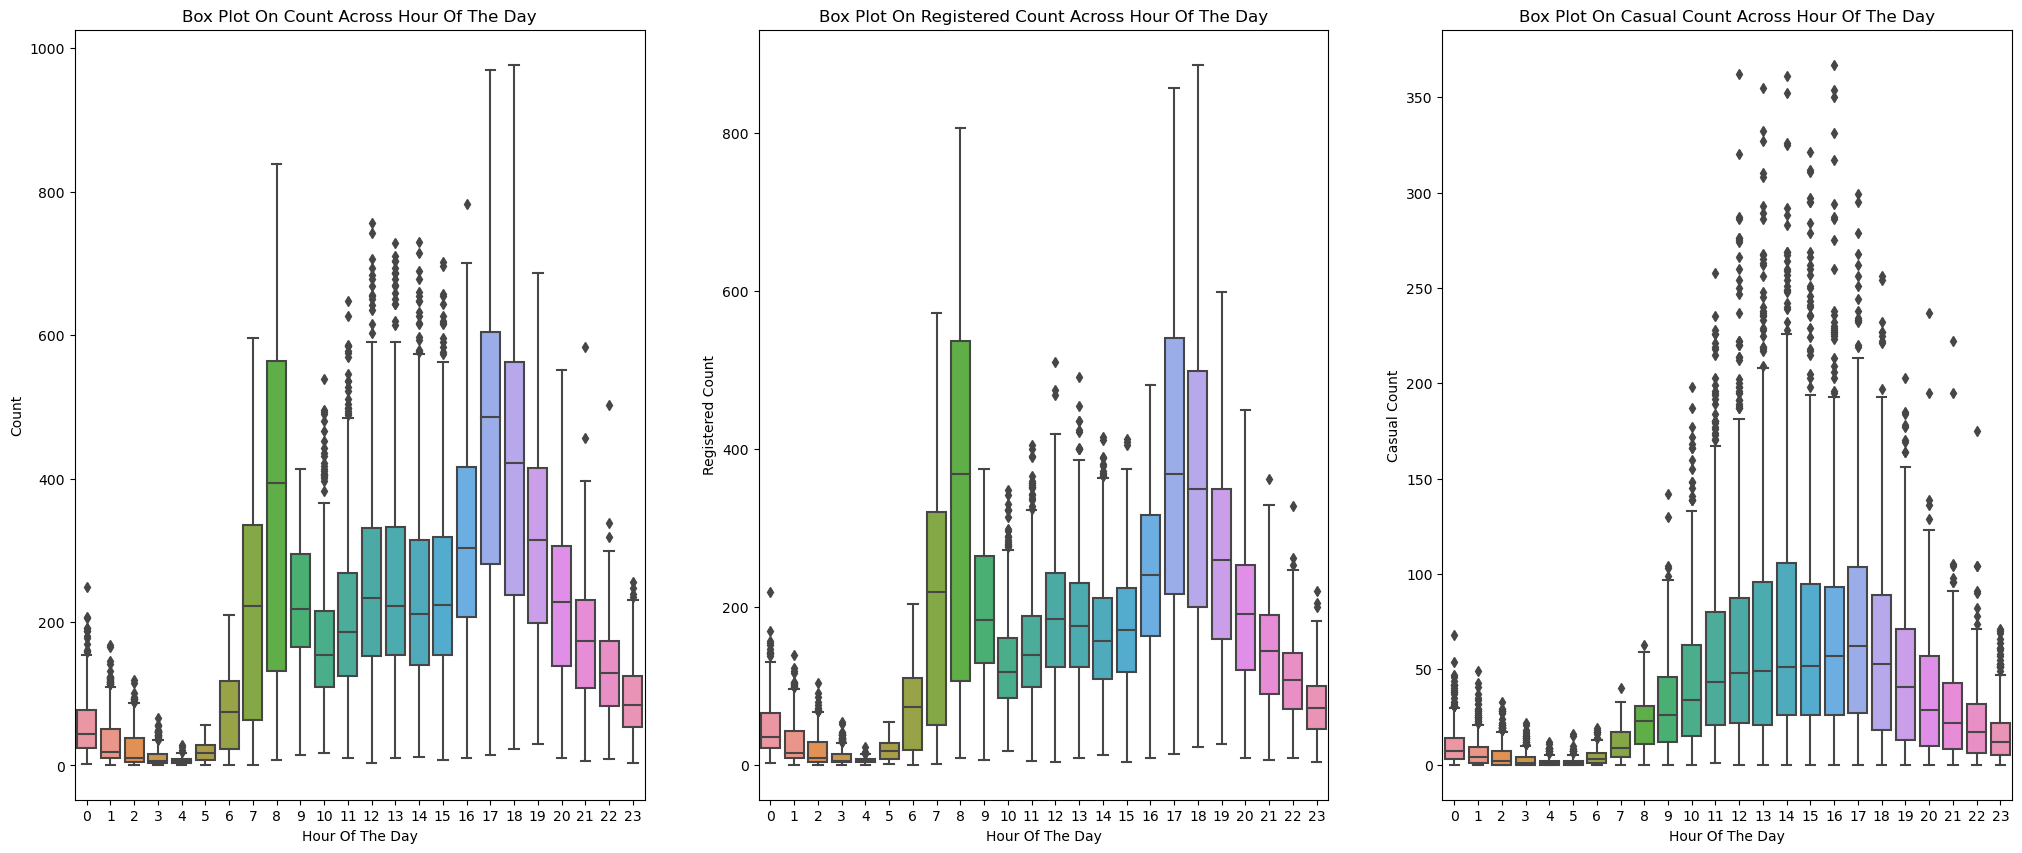

In [47]:
fig, axes = plt.subplots(nrows=1,ncols=3)
fig.set_size_inches(25, 10)
sns.boxplot(data=df_train,y="count",x="hour",ax=axes[0])
sns.boxplot(data=df_train,y="registered",x="hour",ax=axes[1])
sns.boxplot(data=df_train,y="casual",x="hour",ax=axes[2])
axes[0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1].set(xlabel='Hour Of The Day', ylabel='Registered Count',title="Box Plot On Registered Count Across Hour Of The Day")
axes[2].set(xlabel='Hour Of The Day', ylabel='Casual Count',title="Box Plot On Casual Count Across Hour Of The Day")

In [48]:
#Take out outliers!
def delete_outliers(data, df):
    mean = np.mean(data)
    std = np.std(data)
    outliers=np.abs(data-mean) > (3*std)
    df.drop(index=data[outliers].index, inplace=True)
delete_outliers(df_train['count'], df_train)

[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Casual Count'),
 Text(0.5, 1.0, 'Box Plot On Casual Count Across Hour Of The Day')]

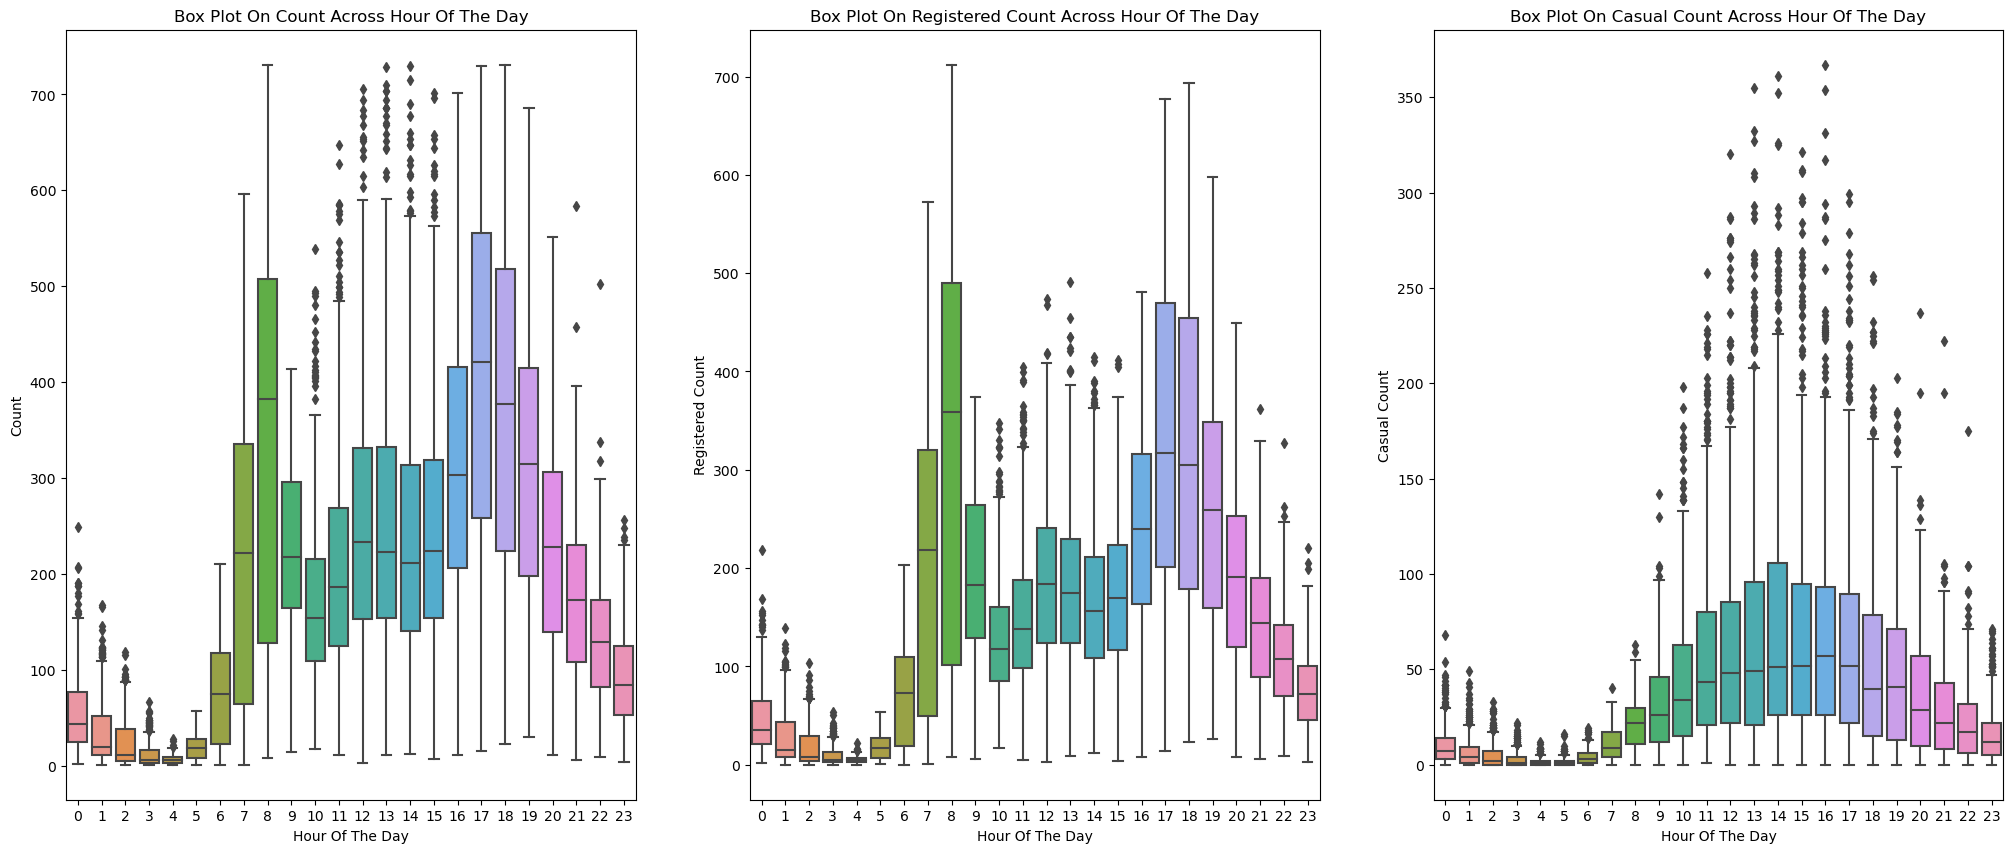

In [49]:
fig, axes = plt.subplots(nrows=1,ncols=3)
fig.set_size_inches(25, 10)
sns.boxplot(data=df_train,y="count",x="hour",ax=axes[0])
sns.boxplot(data=df_train,y="registered",x="hour",ax=axes[1])
sns.boxplot(data=df_train,y="casual",x="hour",ax=axes[2])
axes[0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1].set(xlabel='Hour Of The Day', ylabel='Registered Count',title="Box Plot On Registered Count Across Hour Of The Day")
axes[2].set(xlabel='Hour Of The Day', ylabel='Casual Count',title="Box Plot On Casual Count Across Hour Of The Day")

# look into 4 models!
# 2 for casual and registered with 0 wind
# 2 for casual and registered with filled wind